In [1]:
import os
import h5py
import yaml
import pickle
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.kernels import *
from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *
from sgptools.utils.misc import polygon2candidates

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

gpflow.config.set_default_float(np.float32)
gpflow.config.set_default_jitter(1e-1)

2026-01-08 18:43:15.117490: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 18:43:15.134083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767919395.153026   44092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767919395.158157   44092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767919395.171597   44092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def plot_results(X_candidates, y_candidates, var, 
                 X, waypoints,
                 title=None, fname=None, 
                 figsize=(10, 4), update_waypoint=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    # Reconstruction
    map = ax[0].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=y_candidates)
    ax[0].scatter(X[:, 1], X[:, 0], c='r', s=0.5, marker='.', label='Data')
    ax[0].plot(waypoints[:, 1], waypoints[:, 0], marker='o', c='r', label='Planned Path')
    if update_waypoint is not None:
        ax[0].scatter(waypoints[update_waypoint, 1], waypoints[update_waypoint, 0],
                      marker='o', c='g', label='Update Waypoint', zorder=10)
    ax[0].set_xlabel("X")
    ax[0].set_ylabel("Y")
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[0].set_title("Predicted Bathymetry")
    ax[0].set_aspect('equal')
    ax[0].legend()


    # Prediction Variance
    map = ax[1].scatter(X_candidates[:, 1], X_candidates[:, 0],
                        c=var)
    ax[1].set_xlabel("X")
    ax[1].set_yticks([])
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(map, cax=cax, orientation='vertical')
    ax[1].set_title("Prediction Variance")
    ax[1].set_aspect('equal')

    if title is not None:
        plt.suptitle(title)
    if fname is not None:
        plt.savefig(fname, dpi=300, bbox_inches='tight')
    plt.show()

In [3]:
mission_log = "../launch/data/Coverage-mission-2026-01-08-23-59-54"
num_samples = 5000

# data file
fname = os.path.join(mission_log,
                     "mission-log.hdf5")

# load data
with h5py.File(fname, "r") as f:
    print(f.keys())
    fence_vertices = f["fence_vertices"][:].astype(float)
    X = f["X"][:].astype(float)
    y = f["y"][:].astype(float)

    X_objective = f["X_objective"][:].astype(float)

    X_init = f["X_init"][:].astype(float)
    y_init = f["y_init"][:].astype(float)

    for key in f.keys():
        if 'initial' in key:
            initial_path = f[key][:].astype(float)
        elif 'coverage' in key:
            sol_path = f[key][:].astype(float)

print(f'Mission Log: {mission_log}')
print(f'Number of data samples: {X.shape[0]}')
print(f'Number of reconstruction samples: {num_samples}')

<KeysViewHDF5 ['X', 'X_init', 'X_objective', 'coverage_path-00-04-16', 'fence_vertices', 'initial_path-23-59-54', 'y', 'y_init']>
Mission Log: ../launch/data/Coverage-mission-2026-01-08-23-59-54
Number of data samples: 2999
Number of reconstruction samples: 5000


In [4]:
X_candidates = X_objective
X_scaler = LatLonStandardScaler()
X_scaler.fit(X_candidates)
X_scaler.scale_ *= 0.35
X_candidates = X_scaler.transform(X_candidates)
y_scaler = StandardScaler()
y_scaler.fit(y)

y = y_scaler.transform(y)
X = X_scaler.transform(X)

y_init = y_scaler.transform(y_init)
X_init = X_scaler.transform(X_init)

initial_path = X_scaler.transform(initial_path)
sol_path = X_scaler.transform(sol_path)

In [5]:
# Extract hyperparameters details from config.yaml
config_fname = os.path.join(mission_log, f"config.yaml")
with open(config_fname, 'r') as file:
    config = yaml.safe_load(file)
hyperparameter_config = config.get('hyperparameters', {})
kernel = hyperparameter_config.get('kernel_function', 'RBF')

# Use float32 and higher jitter for deep learning model based kernel functions
if kernel in ['Attentive', 'NeuralSpectral']:
    gpflow.config.set_default_float(np.float32)
    gpflow.config.set_default_jitter(1e-1)
else:
    gpflow.config.set_default_float(np.float64)
    gpflow.config.set_default_jitter(1e-6)

kernel_kwargs = hyperparameter_config.get('kernel', {})
kernel = get_kernel(kernel)(**kernel_kwargs)
noise_variance = float(hyperparameter_config.get('noise_variance', 1e-4))
optimizer_kwargs = config.get('optimizer', {})

2026-01-08 18:43:24.010453: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1.5426502


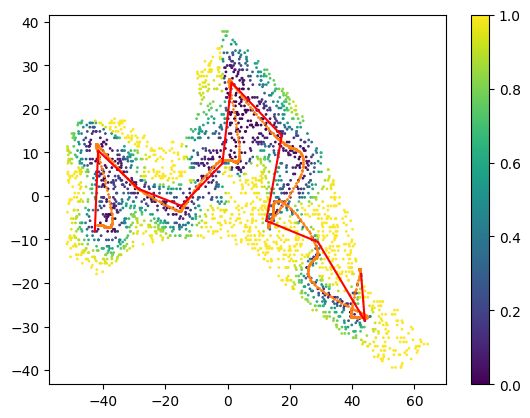

In [6]:
# Init GP model
_, _, _, gpr = get_model_params(np.vstack([X_init]).astype(np.float32), 
                                np.vstack([y_init]).astype(np.float32), 
                                kernel=kernel,
                                noise_variance=noise_variance,
                                return_model=True,
                                verbose=False,
                                max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr.likelihood, params['likelihood'])

mean, var = gpr.predict_f(X_candidates.astype(np.float32))
print(var.numpy().max())

plt.scatter(X_candidates[:, 0], X_candidates[:, 1], s=1, c=var.numpy())
plt.scatter(X_init[:, 0], X_init[:, 1], c='C1', s=1)
plt.plot(initial_path[:, 0], initial_path[:, 1], c='r')
plt.colorbar()

/home/itskalvik/ICPP/sgp-tools/sgptools/utils/misc.py:62: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  Xu = kmeans2(data, num_inducing, minit="points", seed=seed)[0]


1.54265


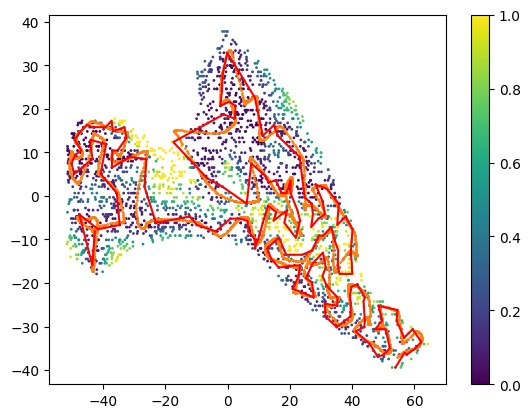

In [7]:
# Init GP model
_, _, _, gpr_post = get_model_params(X.astype(np.float32), 
                                y.astype(np.float32), 
                                kernel=kernel,
                                noise_variance=noise_variance,
                                return_model=True,
                                verbose=False,
                                max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr_post.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr_post.likelihood, params['likelihood'])

mean, var = gpr_post.predict_f(X_candidates.astype(np.float32))
print(var.numpy().max())

plt.scatter(X_candidates[:, 0], X_candidates[:, 1], s=1, c=var.numpy())
plt.scatter(X[:, 0], X[:, 1], c='C1', s=1)
plt.plot(sol_path[:, 0], sol_path[:, 1], c='r')
plt.colorbar()